In [6]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [1]:
# Libraries
# ==============================================================================
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


## Autoregressive forecaster

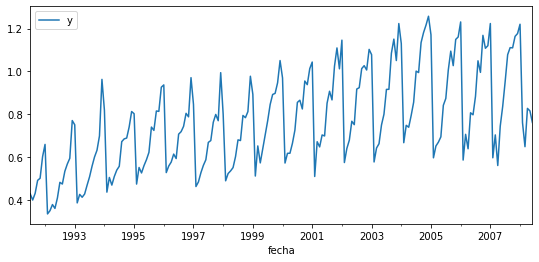

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax, label='y')
ax.legend();

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=Ridge(),
                    lags=3
                )

forecaster.fit(y=data_train)

In [6]:
predictions = forecaster.predict(3)
predictions

DatetimeIndex(['2005-04-01', '2005-05-01', '2005-06-01'], dtype='datetime64[ns]', name='fecha', freq='MS')


2005-07-01    0.800605
2005-08-01    0.784536
2005-09-01    0.772908
Freq: MS, Name: pred, dtype: float64

In [12]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)


# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

AttributeError: 'Series' object has no attribute 'reshape'

In [5]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=Ridge(),
                lags=12
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 9
loop param_grid:   0%|                                    | 0/3 [00:00<?, ?it/s]
                                                                                
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:00<00:00, 18.70it/s]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'alpha': 0.01}



,lags,params,metric,alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.025318,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.025755,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.030505,1.00
6,"[1, 2, 3, 20]",{'alpha': 0.01},0.043651,0.01
7,"[1, 2, 3, 20]",{'alpha': 0.1},0.044092,0.10
8,"[1, 2, 3, 20]",{'alpha': 1},0.047499,1.00
0,"[1, 2, 3]",{'alpha': 0.01},0.058317,0.01
1,"[1, 2, 3]",{'alpha': 0.1},0.058340,0.10
2,"[1, 2, 3]",{'alpha': 1},0.059168,1.00


In [6]:
# Predictors importance
# ==============================================================================
print(forecaster.get_coef())

[ 0.64809274 -0.04771788  0.12042237 -0.10951344 -0.04541451  0.05163303
 -0.14294017  0.0682693   0.05806128  0.26129814]


In [7]:
%config Completer.use_jedi = False


SyntaxError: invalid syntax (2589100856.py, line 2)

Number of observations used for training or as initial window: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.03468267]


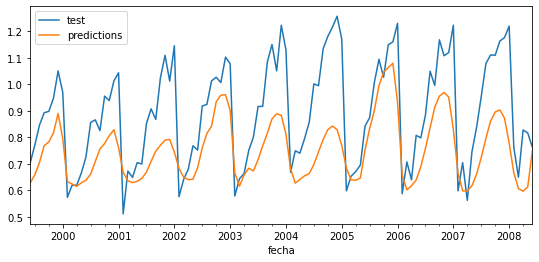

In [8]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
data_train = data[:-n_test]
data_test  = data[-n_test:]

steps = 36
regressor = Ridge()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metrica)

# Se añade el índice temporal a las predicciones
predicciones_backtest = pd.Series(data=predicciones_backtest, index=data_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
predicciones_backtest

fecha
1999-06-01    0.628054
1999-07-01    0.658490
1999-08-01    0.704903
1999-09-01    0.768430
1999-10-01    0.782291
                ...   
2008-02-01    0.666095
2008-03-01    0.606199
2008-04-01    0.596363
2008-05-01    0.613200
2008-06-01    0.749471
Freq: MS, Length: 109, dtype: float64

In [10]:
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)
print(len(predictions_1), predictions_1)
print("")
predictions_2 = forecaster.predict(steps=steps, last_window=data_test[:steps])
print(len(predictions_2), predictions_2)
print("")
predictions_3 = forecaster.predict(steps=steps, last_window=data_test[steps:steps*2])
print(len(predictions_3), predictions_3)
print("")
predictions_4 = forecaster.predict(steps=1, last_window=data_test[steps*2:steps*3])
print(len(predictions_4), predictions_4)
print("")

36 [0.62805402 0.65849009 0.7049027  0.76842957 0.78229061 0.81675206
 0.88962907 0.79510999 0.63196424 0.62364193 0.61460216 0.62801625
 0.63787729 0.66143244 0.70866802 0.75585477 0.77666023 0.80612001
 0.82847543 0.76161866 0.66800681 0.6355973  0.62896426 0.63364716
 0.64462515 0.66862066 0.70928005 0.74726868 0.76967085 0.78982218
 0.79165969 0.74433941 0.68245219 0.64960388 0.63989202 0.64172373]

36 [0.68501418 0.76028453 0.81480616 0.84184704 0.93420127 0.95905883
 0.96068081 0.90197397 0.66551951 0.6151986  0.65785231 0.68324143
 0.67292479 0.71560882 0.76769109 0.81556661 0.86937599 0.88874422
 0.88348098 0.81217344 0.68055109 0.62674797 0.64106504 0.6543804
 0.66286068 0.69736448 0.7447779  0.79160729 0.82874444 0.84237088
 0.82894581 0.76928218 0.68430344 0.63921215 0.63770754 0.64605409]

36 [0.7513656  0.83314981 0.90076554 0.99516327 1.04602096 1.06335169
 1.07962777 0.9319548  0.65772696 0.60127243 0.61721872 0.63853436
 0.68912341 0.7584371  0.83578845 0.91362283 0.955

In [11]:
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

### Autoreg + 1 exogenous predictor
<br>

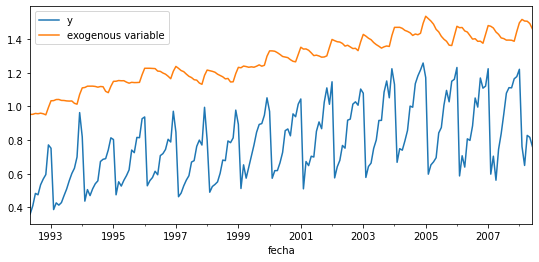

In [12]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Exogenous variable
# ==============================================================================
data_exog = data.rolling(window=10, closed='right').mean() + 0.5
data_exog = data_exog[10:]
data = data[10:]

fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax, label='y')
data_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

data_exog_train = data_exog[:-steps]
data_exog_test  = data_exog[-steps:]

Test error (mse): 0.020306077140235624


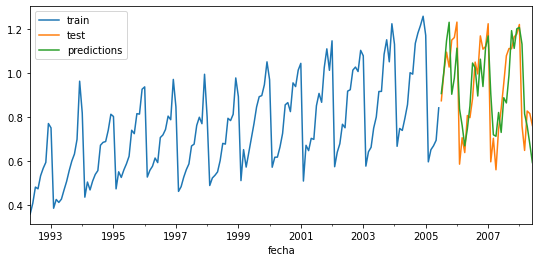

In [13]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=data_train, exog=data_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [14]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        exog        = data_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 12
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:04<00:00,  1.63s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.054245,10,50
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.059871,10,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.062230,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.062298,10,100
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.062390,5,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.065474,10,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.065545,5,50
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.066951,5,100
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.071877,5,50
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.073482,5,100


In [21]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
data_train = data[:-n_test]
data_test  = data[-n_test:]
data_exog_train = data_exog[:-n_test]
data_exog_test  = data_exog[-n_test:]

steps = 36
lags  = 15
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data,
    exog       = data_exog,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

# Verificar predicciones de backtesting
forecaster.fit(y=data_train, exog=data_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=data_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test[:steps], exog=data_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test[steps:steps*2], exog=data_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test[steps*2:steps*3], exog=data_exog_test[steps*3:steps*4])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

Number of observations used for training or as initial window: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[2.1032823e-29]


True

### Autoregressive + n exogenous predictors
<br>

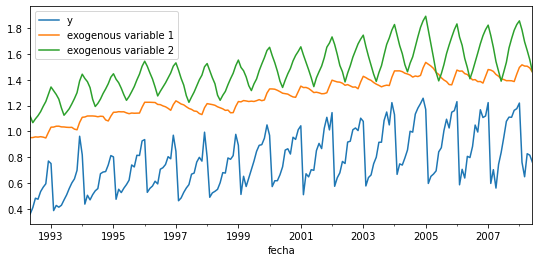

In [24]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=5, closed='right').mean() + 0.7
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.03028522529411059


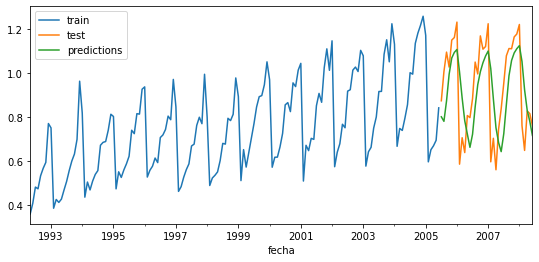

In [25]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

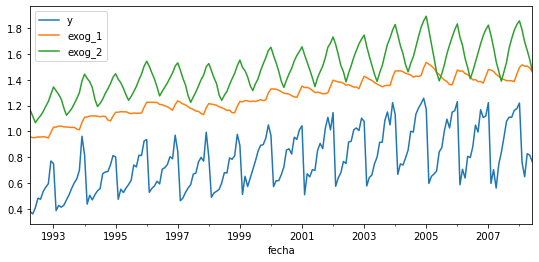

In [26]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [27]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])
# Add datetime index
predictions = pd.Series(data=predictions, index=data_test.index)

# Error
# ==============================================================================
error_mse = mean_squared_error(
            y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.030285034610348982


In [28]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 12
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:10<00:00,  3.53s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.017946,10,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.020676,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.020877,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.021233,5,50
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.025297,5,100
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.027193,10,100
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.027272,5,100
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.027490,5,50
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.027967,10,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.028001,5,50


In [ ]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
data_train = data[:-n_test]
data_test  = data[-n_test:]
data_exog_train = data_exog[:-n_test,]
data_exog_test  = data_exog[-n_test:,]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data,
    exog       = data_exog,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'neg_mean_squared_error',
    verbose    = True
)
print(metrica)

# Verificar predicciones de backtesting
forecaster.fit(y=data_train, exog=data_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=data_exog_test[:steps,])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test[:steps], exog=data_exog_test[steps:steps*2,])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test[steps:steps*2], exog=data_exog_test[steps*2:steps*3,])
predictions_4 = forecaster.predict(steps=1, last_window=data_test[steps*2:steps*3], exog=data_exog_test[steps*3:steps*4,])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

## Información de sesión

In [ ]:
from sinfo import sinfo
sinfo()